In [1]:
# %%
# --- Imports and Config ---
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import random
import gc # Garbage collector

# --- Configuration ---
N_LAGS = 21 # Number of past time steps for sequence input (increased)
N_LEADS = 6 # Predict 6 days ahead (+ current day view)
N_ROLLING_WINDOWS = [7, 14, 28] # Rolling window sizes for context features
SPLIT_DATE = '2016-06-01'
DO_LOG_TRANSFORM = True # Apply log1p transform to Views
SCALE_TARGETS = True # Scale the target variables
SCALE_CONTEXT = True # Scale the context features

# Load the data
data = pd.read_csv('../data/train_1/train_1.csv')
print("Original data shape:", data.shape)

# --- Initial Page Parsing ---
mask = data['Page'].str.split('_').apply(lambda x: len(x) != 4)
problem_rows = data[mask]
if not problem_rows.empty:
    print("Warning: Rows with unexpected Page format found.")

pattern = r'^(?P<Title>.+)_(?P<Project>[^_]+)_(?P<Access>[^_]+)_(?P<Agent>[^_]+)$'
data[['Title', 'Project', 'Access', 'Agent']] = data['Page'].str.extract(pattern, expand=False)

problem_rows = data[data[['Title', 'Project', 'Access', 'Agent']].isnull().any(axis=1)]
if not problem_rows.empty:
   print("Problem rows after regex extraction:")
   print(problem_rows[['Page']].head())

data = data.drop(columns=['Title'])
data['Title'] = data['Page']
data = data.drop(columns=['Page'])
data.drop(['Access', 'Agent', 'Title'], axis=1, inplace=True)

# --- Project Feature Engineering ---
data['CountryCode'] = data['Project'].str.extract(r'^(.*?)\.wikipedia\.org$', expand=False)
# Use assignment instead of inplace=True on fillna
data['CountryCode'] = data['CountryCode'].fillna('unknown')
data['Project_numeric'] = pd.factorize(data['CountryCode'])[0] + 1
data.drop(columns=['CountryCode', 'Project'], inplace=True)

# --- Aggregation by Project ---
date_columns = data.columns[data.columns.str.match(r'\d{4}-\d{2}-\d{2}')]
df_merged = data.groupby('Project_numeric')[date_columns].sum().reset_index()
print("Grouped data shape:", df_merged.shape)
gc.collect() # Clean up memory

# --- Feature Engineering (Sequence = Lags, Context = Current Features) ---
print("Starting Feature Engineering...")
# Melt the dataframe
date_columns_list = df_merged.columns[df_merged.columns.str.match(r'\d{4}-\d{2}-\d{2}')].tolist()
df_long = df_merged.melt(id_vars=['Project_numeric'],
                         value_vars=date_columns_list,
                         var_name='Date',
                         value_name='Views')
del df_merged # Free memory
gc.collect()

df_long['Date'] = pd.to_datetime(df_long['Date'])
df_long['Views'] = pd.to_numeric(df_long['Views'], errors='coerce')
# Use assignment instead of inplace=True on fillna
df_long['Views'] = df_long['Views'].fillna(0)
df_long.sort_values(by=['Project_numeric', 'Date'], inplace=True)
df_long.reset_index(drop=True, inplace=True)

# --- Log Transform (Optional but Recommended) ---
if DO_LOG_TRANSFORM:
    df_long['LogViews'] = np.log1p(df_long['Views'])
    print("Applied log1p transformation to Views.")
    value_col = 'LogViews'
else:
    value_col = 'Views'

# --- Create Lag Features (for LSTM Sequence Input) ---
# Optimized approach to avoid fragmentation
print(f"Creating {N_LAGS} lag features for '{value_col}'...")
lag_data = {}
for i in range(1, N_LAGS + 1):
    lag_data[f'lag{i}'] = df_long.groupby('Project_numeric')[value_col].shift(i)
lag_df = pd.DataFrame(lag_data)
sequence_features = [f'lag{i}' for i in range(N_LAGS, 0, -1)] # Order: lagN -> lag1

# --- Create Lead Features (Targets) ---
# Optimized approach
print(f"Creating {N_LEADS} lead features (targets)...")
lead_data = {}
target_features = [value_col] # Include current value as first target
for i in range(1, N_LEADS + 1):
    lead_col_name = f'lead{i}'
    lead_data[lead_col_name] = df_long.groupby('Project_numeric')[value_col].shift(-i)
    target_features.append(lead_col_name)
lead_df = pd.DataFrame(lead_data)

# --- Create CURRENT Context Features ---
print("Creating current context features...")
# Date Features (Current)
df_long['dayofweek'] = df_long['Date'].dt.dayofweek
df_long['month'] = df_long['Date'].dt.month
df_long['dayofyear'] = df_long['Date'].dt.dayofyear
# df_long['year'] = df_long['Date'].dt.year # Optional

# Cyclical Date Features (Current)
df_long['dayofweek_sin'] = np.sin(2 * np.pi * df_long['dayofweek'] / 7.0)
df_long['dayofweek_cos'] = np.cos(2 * np.pi * df_long['dayofweek'] / 7.0)
df_long['month_sin'] = np.sin(2 * np.pi * df_long['month'] / 12.0)
df_long['month_cos'] = np.cos(2 * np.pi * df_long['month'] / 12.0)
df_long['dayofyear_sin'] = np.sin(2 * np.pi * df_long['dayofyear'] / 365.25)
df_long['dayofyear_cos'] = np.cos(2 * np.pi * df_long['dayofyear'] / 365.25)

# Rolling Window Features (Current context, using data PRIOR to current day)
# Optimized approach
rolling_data = {}
print(f"Creating rolling window features for windows: {N_ROLLING_WINDOWS}...")
grouped_data = df_long.groupby('Project_numeric')[value_col]
for window in N_ROLLING_WINDOWS:
    # Shift(1) ensures rolling window uses data PRIOR to the current day
    rolling_data[f'rolling_mean_{window}'] = grouped_data.shift(1).rolling(window=window, min_periods=1).mean()
    rolling_data[f'rolling_std_{window}'] = grouped_data.shift(1).rolling(window=window, min_periods=1).std()
rolling_df = pd.DataFrame(rolling_data)
# Fill NaNs in rolling std dev (can happen if window has only 1 point or constant values)
rolling_df.fillna(0, inplace=True) # Fill std=NaN with 0

# Define context features list
context_features = [
    'Project_numeric', # Keep as context
    'dayofweek_sin', 'dayofweek_cos',
    'month_sin', 'month_cos',
    'dayofyear_sin', 'dayofyear_cos',
    # 'year' # Optional
] + rolling_df.columns.tolist() # Add all rolling feature names

# --- Combine all features ---
print("Concatenating all features...")
# Select necessary original columns + add new ones
cols_to_keep = ['Project_numeric', 'Date', value_col] + \
               [f for f in context_features if f in df_long.columns] # Keep original context cols if they exist
df_final = pd.concat([df_long[cols_to_keep], lag_df, lead_df, rolling_df], axis=1)
del df_long, lag_df, lead_df, rolling_df # Free memory
gc.collect()

# --- Drop Rows with NaNs ---
print("Dropping rows with NaNs...")
initial_rows = df_final.shape[0]
# Check NaNs in lags, leads, and rolling features that require minimum periods
# Rolling mean should be fine with min_periods=1, lags require N_LAGS, leads require N_LEADS
cols_to_check_for_nan = sequence_features + target_features
df_final.dropna(subset=cols_to_check_for_nan, inplace=True)
print(f"Dropped {initial_rows - df_final.shape[0]} rows due to NaNs.")
print("Final DataFrame shape:", df_final.shape)

# --- Final Feature Lists ---
print(f"\nSequence Features ({len(sequence_features)}): {sequence_features}")
print(f"Context Features ({len(context_features)}): {context_features}")
print(f"Target Features ({len(target_features)}): {target_features}")


# --- Split data ---
print(f"\nSplitting data at {SPLIT_DATE}...")
train_df = df_final[df_final['Date'] < SPLIT_DATE].copy()
test_df = df_final[df_final['Date'] >= SPLIT_DATE].copy()
print(f"Train df shape: {train_df.shape}")
print(f"Test df shape: {test_df.shape}")

# --- Scaling ---
print("Scaling features...")
# Scale sequence features (Lags of value_col)
scaler_seq = StandardScaler()
train_df[sequence_features] = scaler_seq.fit_transform(train_df[sequence_features])
test_df[sequence_features] = scaler_seq.transform(test_df[sequence_features])
print("Sequence features scaled.")

# Scale context features (Optional but recommended)
if SCALE_CONTEXT:
    scaler_context = StandardScaler()
    train_df[context_features] = scaler_context.fit_transform(train_df[context_features])
    test_df[context_features] = scaler_context.transform(test_df[context_features])
    print("Context features scaled.")
else:
    print("Context features were NOT scaled.")


# Scale target features (Optional)
if SCALE_TARGETS:
    scaler_target = StandardScaler()
    train_df[target_features] = scaler_target.fit_transform(train_df[target_features])
    test_df[target_features] = scaler_target.transform(test_df[target_features])
    print("Target features scaled.")
else:
    print("Target features were NOT scaled.")

TARGETS_SCALED = SCALE_TARGETS # Flag for inverse transform later
CONTEXT_SCALED = SCALE_CONTEXT

# --- Store Test Dates ---
print("Storing test dates...")
test_dates_list = test_df['Date'].tolist()
print(f"Stored {len(test_dates_list)} dates from the test set.")

# --- Clean up ---
print("Deleting final pandas DataFrame to free memory...")
del df_final # Keep train_df, test_df for tensor creation
gc.collect()
print("\n--- Data Preparation Cell Complete ---")

Original data shape: (145063, 551)
Grouped data shape: (8, 551)
Starting Feature Engineering...
Applied log1p transformation to Views.
Creating 21 lag features for 'LogViews'...
Creating 6 lead features (targets)...
Creating current context features...
Creating rolling window features for windows: [7, 14, 28]...
Concatenating all features...
Dropping rows with NaNs...
Dropped 216 rows due to NaNs.
Final DataFrame shape: (4184, 43)

Sequence Features (21): ['lag21', 'lag20', 'lag19', 'lag18', 'lag17', 'lag16', 'lag15', 'lag14', 'lag13', 'lag12', 'lag11', 'lag10', 'lag9', 'lag8', 'lag7', 'lag6', 'lag5', 'lag4', 'lag3', 'lag2', 'lag1']
Context Features (13): ['Project_numeric', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_28', 'rolling_std_28']
Target Features (7): ['LogViews', 'lead1', 'lead2', 'lead3', 'lead4', 'lead5', 'lead6']

Splitting data at 2016-0

In [2]:
# %%
# --- Prepare Tensors & DataLoaders ---
import torch
from torch.utils.data import TensorDataset, DataLoader
import gc

print("\nCreating tensors...")

# Ensure required DFs and feature lists exist
required_vars_tensor = ['train_df', 'test_df', 'sequence_features', 'context_features', 'target_features']
for var in required_vars_tensor:
    if var not in locals():
        raise NameError(f"Variable '{var}' needed for tensor creation is not defined.")

# Training Data
# Sequence: Needs unsqueeze(-1) because features_per_step = 1
X_train_seq = torch.tensor(train_df[sequence_features].values, dtype=torch.float32).unsqueeze(-1)
X_train_context = torch.tensor(train_df[context_features].values, dtype=torch.float32)
y_train = torch.tensor(train_df[target_features].values, dtype=torch.float32)

# Testing Data
X_test_seq = torch.tensor(test_df[sequence_features].values, dtype=torch.float32).unsqueeze(-1)
X_test_context = torch.tensor(test_df[context_features].values, dtype=torch.float32)
y_test = torch.tensor(test_df[target_features].values, dtype=torch.float32)

print("Train tensors shape (Seq, Context, Target):", X_train_seq.shape, X_train_context.shape, y_train.shape)
print("Test tensors shape (Seq, Context, Target):", X_test_seq.shape, X_test_context.shape, y_test.shape)

# --- Create DataLoaders ---
# DataLoader yields batches of (sequence_data, context_data, target_data)
batch_size = 128 # Adjust as needed based on memory

train_dataset = TensorDataset(X_train_seq, X_train_context, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2) # Added pin_memory & workers
print(f"Train DataLoader created with batch size {batch_size}.")

test_dataset = TensorDataset(X_test_seq, X_test_context, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
print(f"Test DataLoader created with batch size {batch_size}.")

# --- Clean up DataFrames ---
print("Deleting train/test DataFrames...")
del train_df, test_df
gc.collect()
print("DataFrames deleted.")
print("\n--- Tensor/DataLoader Preparation Cell Complete ---")


Creating tensors...
Train tensors shape (Seq, Context, Target): torch.Size([2520, 21, 1]) torch.Size([2520, 14]) torch.Size([2520, 7])
Test tensors shape (Seq, Context, Target): torch.Size([1664, 21, 1]) torch.Size([1664, 14]) torch.Size([1664, 7])
Train DataLoader created with batch size 128.
Test DataLoader created with batch size 128.
Deleting train/test DataFrames...
DataFrames deleted.

--- Tensor/DataLoader Preparation Cell Complete ---


In [3]:
# %%
# --- Define the LSTM Model (UPDATED with Bidirectionality) ---

import torch
import torch.nn as nn

class LSTMForecastModel(nn.Module):
    # Takes sequence_input_size (features per step, typically 1 here) AND context_input_size
    def __init__(self, sequence_input_size, context_input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sequence_input_size = sequence_input_size
        self.context_input_size = context_input_size

        # --- UPDATED: Added bidirectional=True ---
        self.lstm = nn.LSTM(sequence_input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0,
                            bidirectional=True) # Process sequence forward and backward

        # --- UPDATED: Adjusted fc1 input size for bidirectional LSTM ---
        # Input = (LSTM hidden_size * 2 for bidir) + context_input_size
        self.fc1 = nn.Linear((hidden_size * 2) + context_input_size, hidden_size * 2)
        # --- End Update ---

        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size * 2, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)

    # Takes BOTH x_seq and x_context
    def forward(self, x_seq, x_context):
        # Initialize hidden and cell states
        # For bidirectional, hidden/cell state shape is (num_layers * 2, batch, hidden_size)
        h0 = torch.zeros(self.num_layers * 2, x_seq.size(0), self.hidden_size).to(x_seq.device)
        c0 = torch.zeros(self.num_layers * 2, x_seq.size(0), self.hidden_size).to(x_seq.device)

        # --- Validate input shapes (no change needed here) ---
        if x_seq.shape[2] != self.sequence_input_size:
             raise ValueError(f"Input sequence feature size ({x_seq.shape[2]}) does not match model expected sequence input size ({self.sequence_input_size})")
        if x_context.shape[1] != self.context_input_size:
             raise ValueError(f"Input context feature size ({x_context.shape[1]}) does not match model expected context input size ({self.context_input_size})")

        # Pass sequence through LSTM
        # lstm_out shape: (batch, seq_len, hidden_size * 2) if batch_first=True
        # hidden shape: (num_layers * 2, batch, hidden_size)
        lstm_out, (hidden, _) = self.lstm(x_seq, (h0, c0))

        # --- UPDATED: Extract and combine final forward and backward hidden states ---
        # hidden[-2,:,:] is the last forward layer's hidden state
        # hidden[-1,:,:] is the last backward layer's hidden state
        last_hidden_state_fwd = hidden[-2,:,:] # Shape: (batch, hidden_size)
        last_hidden_state_bwd = hidden[-1,:,:] # Shape: (batch, hidden_size)
        # Concatenate them to get the combined representation
        last_hidden_state_combined = torch.cat((last_hidden_state_fwd, last_hidden_state_bwd), dim=1) # Shape: (batch, hidden_size * 2)
        # --- End Update ---


        # Concatenate combined LSTM output with context features
        # Shape should be (batch, (hidden_size * 2) + context_input_size) which matches fc1 input
        combined = torch.cat((last_hidden_state_combined, x_context), dim=1)

        # Pass through fully connected layers (no change needed here as fc1 input size was adjusted)
        out = self.fc1(combined)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

print("Model Class Defined (Bidirectional LSTM + Context Features).")

Model Class Defined (Bidirectional LSTM + Context Features).


Using device: cuda
Derived SEQUENCE_INPUT_SIZE: 1
Derived CONTEXT_INPUT_SIZE: 14
Derived OUTPUT_SIZE: 7

Model Architecture (Increased Capacity):
LSTMForecastModel(
  (lstm): LSTM(1, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc1): Linear(in_features=526, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
)

Total trainable parameters: 4020743

Model Architecture:
LSTMForecastModel(
  (lstm): LSTM(1, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc1): Linear(in_features=526, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_featu

/home/tim/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Train Loss: 0.393914, Test Loss: 0.053063, Duration: 0.58s
   -> Saved Best Model (Epoch 1)
Epoch [2/30], Train Loss: 0.069656, Test Loss: 0.037478, Duration: 0.43s
   -> Saved Best Model (Epoch 2)
Epoch [3/30], Train Loss: 0.050279, Test Loss: 0.030084, Duration: 0.36s
   -> Saved Best Model (Epoch 3)
Epoch [4/30], Train Loss: 0.045520, Test Loss: 0.029962, Duration: 0.42s
   -> Saved Best Model (Epoch 4)
Epoch [5/30], Train Loss: 0.041645, Test Loss: 0.031752, Duration: 0.34s
Epoch [6/30], Train Loss: 0.038504, Test Loss: 0.036532, Duration: 0.37s
Epoch [7/30], Train Loss: 0.036680, Test Loss: 0.035382, Duration: 0.35s
Epoch [8/30], Train Loss: 0.032878, Test Loss: 0.029892, Duration: 0.36s
   -> Saved Best Model (Epoch 8)
Epoch [9/30], Train Loss: 0.033163, Test Loss: 0.027648, Duration: 0.39s
   -> Saved Best Model (Epoch 9)
Epoch [10/30], Train Loss: 0.031609, Test Loss: 0.029698, Duration: 0.39s
Epoch [11/30], Train Loss: 0.028855, Test Loss: 0.032846, Duration: 0.3

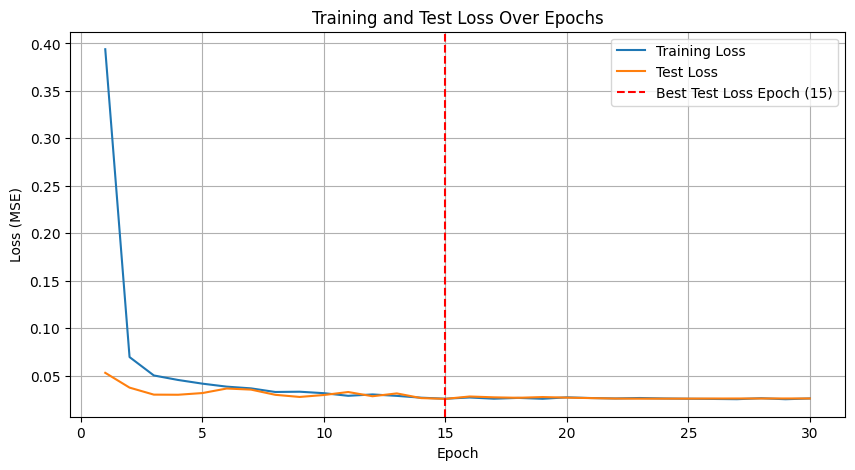


Calculating Final Evaluation Metrics on Best Model...


LSTMForecastModel(
  (lstm): LSTM(1, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc1): Linear(in_features=526, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
)

In [ ]:
# %%
# --- Model Instantiation, Training Loop, Evaluation ---

import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time # For timing epochs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# --- Hyperparameters ---
try:
    SEQUENCE_INPUT_SIZE = X_train_seq.shape[2] # Should be 1
    CONTEXT_INPUT_SIZE = X_train_context.shape[1] # Number of context features
    OUTPUT_SIZE = y_train.shape[1] # Number of target features
    print(f"Derived SEQUENCE_INPUT_SIZE: {SEQUENCE_INPUT_SIZE}")
    print(f"Derived CONTEXT_INPUT_SIZE: {CONTEXT_INPUT_SIZE}")
    print(f"Derived OUTPUT_SIZE: {OUTPUT_SIZE}")
except NameError:
    raise NameError("Input tensors (X_train_seq, X_train_context, y_train) not found. Run Cell 2 first.")

# *** INCREASED CAPACITY ***
HIDDEN_SIZE = 256    # LSTM hidden units (Increased from 128)
NUM_LAYERS = 3      # Number of LSTM layers (Increased from 2)
# *************************

LEARNING_RATE = 0.001 # May need adjustment for bigger model
NUM_EPOCHS = 30     # Keep or increase slightly, monitor loss
DROPOUT_PROB = 0.3  # Keep or potentially increase slightly if overfitting occurs
WEIGHT_DECAY = 1e-6 # Keep L2 regularization

# Instantiate the model (No changes here, it uses the new hyperparameter values)
model = LSTMForecastModel(
    sequence_input_size=SEQUENCE_INPUT_SIZE,
    context_input_size=CONTEXT_INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=OUTPUT_SIZE,
    dropout_prob=DROPOUT_PROB
).to(device)

# (Criterion, Optimizer, Scheduler remain the same for now)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)


# (Print model architecture and trainable parameters)
print("\nModel Architecture (Increased Capacity):")
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params}") # Note this number will increase


print("\nModel Architecture:")
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params}")


# %% --- Training Loop ---
print("\nStarting Training...")
train_losses = []
test_losses = []
best_test_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    # DataLoader yields (seq_data, context_data, targets)
    for batch_idx, (seq_data, context_data, targets) in enumerate(train_loader):
        seq_data = seq_data.to(device)
        context_data = context_data.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(seq_data, context_data)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        # Optional: Gradient Clipping
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # --- Validation ---
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for seq_data, context_data, targets in test_loader:
            seq_data = seq_data.to(device)
            context_data = context_data.to(device)
            targets = targets.to(device)

            outputs = model(seq_data, context_data)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item()

    epoch_test_loss = running_test_loss / len(test_loader)
    test_losses.append(epoch_test_loss)

    # Update LR scheduler based on test loss
    scheduler.step(epoch_test_loss)

    epoch_duration = time.time() - start_time
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {epoch_train_loss:.6f}, Test Loss: {epoch_test_loss:.6f}, Duration: {epoch_duration:.2f}s")

    # Save the best model based on validation loss
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        torch.save(model.state_dict(), 'best_lstm_context_model.pth')
        print(f"   -> Saved Best Model (Epoch {epoch+1})")


print("Training finished.")

# Load the best model for final evaluation
print(f"\nLoading best model with Test Loss: {best_test_loss:.6f}")
model.load_state_dict(torch.load('best_lstm_context_model.pth'))


# %% --- Plotting Loss ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss Over Epochs')
plt.axvline(test_losses.index(min(test_losses)) + 1, color='r', linestyle='--', label=f'Best Test Loss Epoch ({test_losses.index(min(test_losses))+1})')
plt.legend()
plt.grid(True)
plt.show()


# %% --- Final Evaluation Metrics ---
print("\nCalculating Final Evaluation Metrics on Best Model...")
model.eval()


Length of test_dataset: 1664
Length of test_dates_list: 1664
Plotting 7 target days.
Processing plot for test index 1029...
Index 1029: Applied expm1 for log transform.
Processing plot for test index 1303...
Index 1303: Applied expm1 for log transform.
Processing plot for test index 432...
Index 432: Applied expm1 for log transform.
Processing plot for test index 1002...
Index 1002: Applied expm1 for log transform.
Processing plot for test index 1223...
Index 1223: Applied expm1 for log transform.
Processing plot for test index 1183...
Index 1183: Applied expm1 for log transform.
Processing plot for test index 1081...
Index 1081: Applied expm1 for log transform.


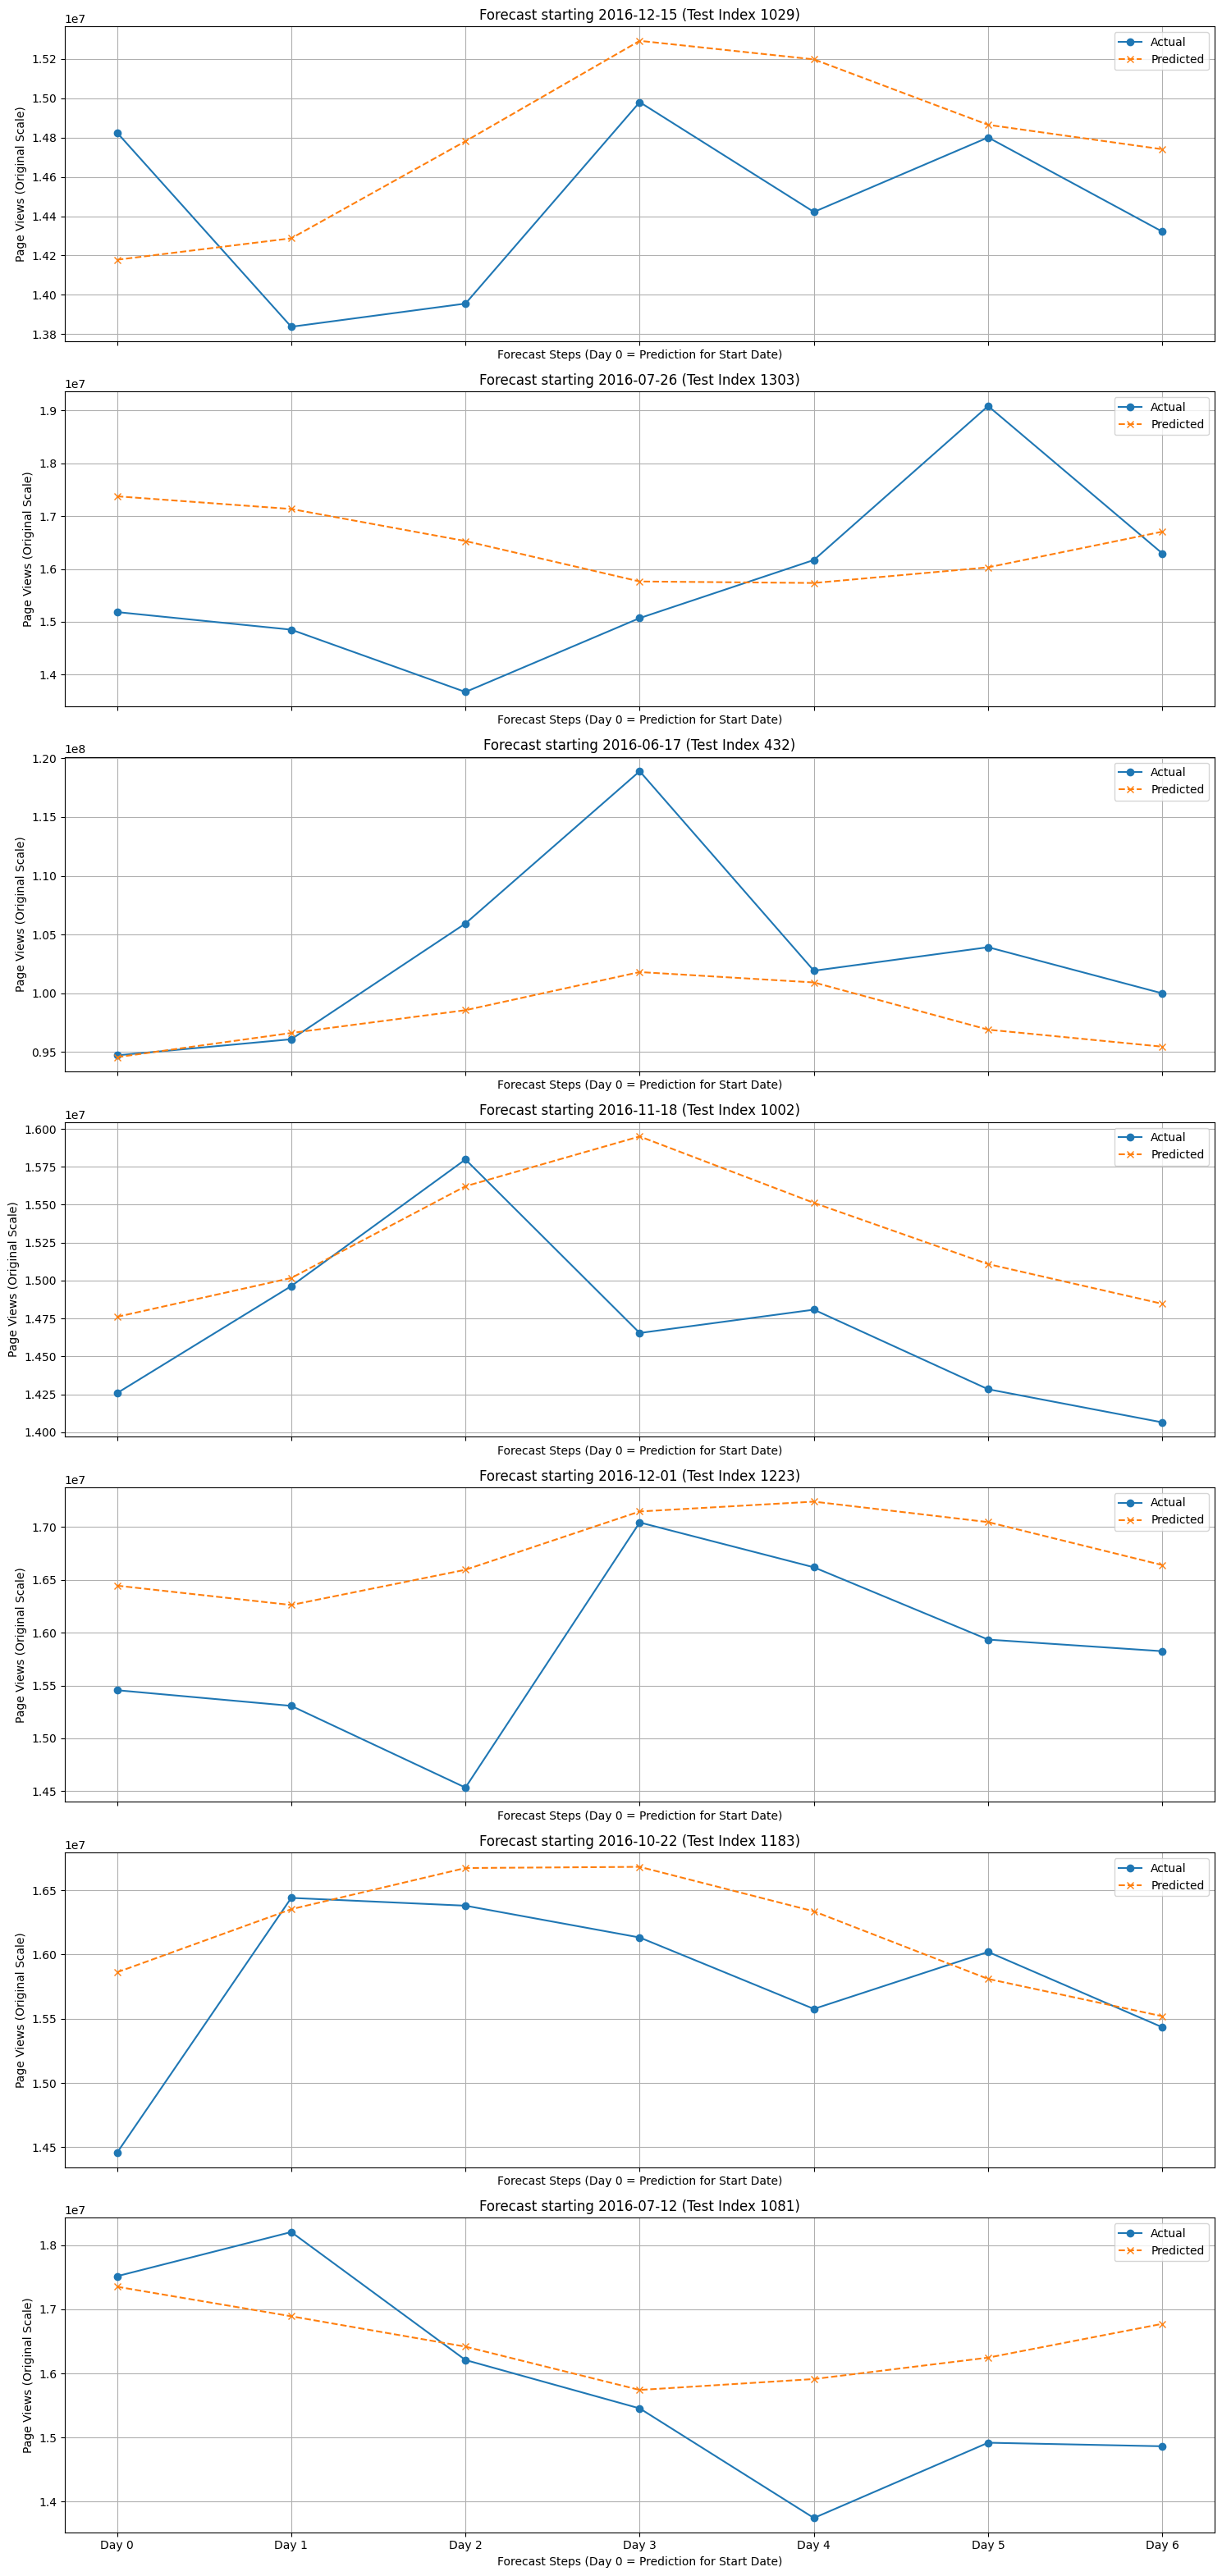

In [9]:
# %%
# --- Prediction and Visualization (using reverted model structure) ---

import matplotlib.pyplot as plt
import random
import torch
import numpy as np
import gc

# Check if essential variables exist
essential_vars_viz = ['test_dataset', 'test_dates_list', 'model', 'device', 'TARGETS_SCALED', 'DO_LOG_TRANSFORM']
if TARGETS_SCALED: essential_vars_viz.append('scaler_target')
if CONTEXT_SCALED: essential_vars_viz.append('scaler_context') # Context scaler needed if context was scaled

vars_exist = True
for var_name in essential_vars_viz:
    if var_name not in locals():
        print(f"ERROR: Essential variable '{var_name}' is not defined for visualization.")
        vars_exist = False

if vars_exist:
    print(f"Length of test_dataset: {len(test_dataset)}")
    print(f"Length of test_dates_list: {len(test_dates_list)}")
    if len(test_dataset) != len(test_dates_list):
         print("Warning: Length mismatch between test_dataset and test_dates_list!")

    try:
        num_targets = y_test.shape[1]
        target_labels = [f'Day {i}' for i in range(num_targets)]
        forecast_horizon = list(range(num_targets))
        print(f"Plotting {num_targets} target days.")
    except NameError:
        print("Warning: y_test not found, assuming 7 target days for plotting.")
        num_targets = 7
        target_labels = [f'Day {i}' for i in range(num_targets)]
        forecast_horizon = list(range(num_targets))

    # --- Plotting Setup ---
    num_samples_to_plot = 7
    if len(test_dataset) == 0:
        print("Test dataset is empty. Cannot generate plots.")
        num_samples_to_plot = 0
    elif len(test_dataset) < num_samples_to_plot:
        print(f"Warning: Requested {num_samples_to_plot} plots, but test dataset only has {len(test_dataset)} samples.")
        num_samples_to_plot = len(test_dataset)

    if num_samples_to_plot > 0:
        random_indices = random.sample(range(len(test_dataset)), num_samples_to_plot)
        n_plots = len(random_indices)
        ncols = 1
        nrows = n_plots

        fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 4.5), sharex=True, squeeze=False)
        axes = axes.flatten()

        model.eval() # Ensure model is in evaluation mode
        with torch.no_grad():
            plot_counter = 0
            for i, idx in enumerate(random_indices):
                print(f"Processing plot for test index {idx}...")
                try:
                    # --- Get data from dataset ---
                    # Dataset now yields (sequence, context, target)
                    sample_seq, sample_context, sample_actual_scaled = test_dataset[idx]

                    # Get the corresponding date
                    sample_date = test_dates_list[idx]

                    # --- Prepare data for model ---
                    # Add batch dimension and move to device
                    sample_seq_batch = sample_seq.unsqueeze(0).to(device)     # Shape: (1, seq_len, 1)
                    sample_context_batch = sample_context.unsqueeze(0).to(device) # Shape: (1, context_features)

                    # --- Get prediction ---
                    # Model now takes seq and context
                    predicted_scaled = model(sample_seq_batch, sample_context_batch).squeeze(0).cpu().numpy() # Shape: (output_size,)

                    # --- Inverse Transform ---
                    actual_series = sample_actual_scaled.numpy() # Keep original scaled actuals

                    if TARGETS_SCALED:
                        predicted_series_inv = scaler_target.inverse_transform(predicted_scaled.reshape(1, -1))[0]
                        actual_series_inv = scaler_target.inverse_transform(actual_series.reshape(1, -1))[0]
                        plot_ylabel = "Page Views (Original Scale)"
                        # Reverse log transform if applied
                        if DO_LOG_TRANSFORM:
                             predicted_series_final = np.expm1(predicted_series_inv)
                             actual_series_final = np.expm1(actual_series_inv)
                             print(f"Index {idx}: Applied expm1 for log transform.")
                        else:
                             predicted_series_final = predicted_series_inv
                             actual_series_final = actual_series_inv
                    else: # Targets were not scaled
                        predicted_series_final = predicted_scaled
                        actual_series_final = actual_series # Already in original scale (or log scale)
                        plot_ylabel = "Page Views (Not Scaled)"
                        # Reverse log transform if it was applied
                        if DO_LOG_TRANSFORM:
                             predicted_series_final = np.expm1(predicted_series_final)
                             actual_series_final = np.expm1(actual_series_final)
                             plot_ylabel = "Page Views (Original Scale - Log Transformed)"
                             print(f"Index {idx}: Applied expm1 for log transform.")

                    # --- Plotting ---
                    ax = axes[plot_counter]
                    ax.plot(forecast_horizon, actual_series_final, marker='o', linestyle='-', label='Actual')
                    ax.plot(forecast_horizon, predicted_series_final, marker='x', linestyle='--', label='Predicted')

                    try: title_date = sample_date.strftime('%Y-%m-%d')
                    except: title_date = str(sample_date)
                    ax.set_title(f"Forecast starting {title_date} (Test Index {idx})")
                    ax.set_xlabel(f"Forecast Steps ({target_labels[0]} = Prediction for Start Date)")
                    ax.set_ylabel(plot_ylabel)
                    ax.legend()
                    ax.grid(True)
                    ax.set_xticks(forecast_horizon)
                    ax.set_xticklabels(target_labels)

                    plot_counter += 1

                except Exception as e:
                    print(f"ERROR processing plot for index {idx}: {e}")
                    import traceback
                    traceback.print_exc()

        # Clean up unused axes
        for j in range(plot_counter, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
        gc.collect() # Clean up plot memory

else:
    print("Cannot generate plots because essential variables are missing.")

In [ ]:
# %%
# --- Ray Tune Hyperparameter Optimization ---
# Replaces the manual training/evaluation cell

import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os
import numpy as np
import time
import gc

# --- Ensure Data Tensors are Loaded ---
required_tensors = ['X_train_seq', 'X_train_context', 'y_train', 'X_test_seq', 'X_test_context', 'y_test']
print("Checking for required tensors...")
for tensor_name in required_tensors:
    if tensor_name not in locals():
        raise NameError(f"Tensor '{tensor_name}' not found. Please run Cell 1 and Cell 2 first.")
    else:
        print(f"  - Found {tensor_name} with shape: {locals()[tensor_name].shape}")

# --- Model Definition (Copied for Ray Tune Workers) ---
# It's often necessary to define the model class within the scope
# accessible by the objective function, or ensure it's importable.
# Copy the *exact* bidirectional LSTMForecastModel class definition here:
class LSTMForecastModel(nn.Module):
    def __init__(self, sequence_input_size, context_input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sequence_input_size = sequence_input_size
        self.context_input_size = context_input_size

        self.lstm = nn.LSTM(sequence_input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0,
                            bidirectional=True) # Ensure bidirectional is True

        self.fc1 = nn.Linear((hidden_size * 2) + context_input_size, hidden_size * 2) # Adjusted for bidir
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size * 2, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x_seq, x_context):
        # Initialize hidden state for bidirectional
        h0 = torch.zeros(self.num_layers * 2, x_seq.size(0), self.hidden_size).to(x_seq.device)
        c0 = torch.zeros(self.num_layers * 2, x_seq.size(0), self.hidden_size).to(x_seq.device)

        # Input validation (optional, can be removed for speed in tuning)
        # if x_seq.shape[2] != self.sequence_input_size: raise ValueError("Seq input size mismatch")
        # if x_context.shape[1] != self.context_input_size: raise ValueError("Context input size mismatch")

        lstm_out, (hidden, _) = self.lstm(x_seq, (h0, c0))

        # Combine final forward and backward states
        last_hidden_state_fwd = hidden[-2,:,:]
        last_hidden_state_bwd = hidden[-1,:,:]
        last_hidden_state_combined = torch.cat((last_hidden_state_fwd, last_hidden_state_bwd), dim=1)

        # Concatenate LSTM output with context
        combined = torch.cat((last_hidden_state_combined, x_context), dim=1)

        # Pass through dense layers
        out = self.fc1(combined)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

# --- Objective Function for Ray Tune ---
def train_lstm_objective(config):
    """Objective function for Ray Tune."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- DataLoaders ---
    batch_size = config["batch_size"]
    train_dataset = TensorDataset(X_train_seq, X_train_context, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True if device.type == 'cuda' else False)

    test_dataset = TensorDataset(X_test_seq, X_test_context, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True if device.type == 'cuda' else False)

    # --- Model ---
    model = LSTMForecastModel(
        sequence_input_size=X_train_seq.shape[2],
        context_input_size=X_train_context.shape[1],
        hidden_size=config["hidden_size"],
        num_layers=config["num_layers"],
        output_size=y_train.shape[1],
        dropout_prob=config["dropout_prob"]
    ).to(device)

    # --- Loss and Optimizer ---
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=config["lr"],
        weight_decay=config.get("weight_decay", 0)
    )

    # --- Training Loop (Fewer Epochs for Tuning) ---
    num_tune_epochs = 15

    for epoch in range(num_tune_epochs):
        model.train()
        running_train_loss = 0.0 # Accumulate train loss for reporting
        for seq_data, context_data, targets in train_loader:
            seq_data, context_data, targets = seq_data.to(device), context_data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(seq_data, context_data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        epoch_train_loss = running_train_loss / len(train_loader) # Calculate average train loss


        # --- Validation Phase ---
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for seq_data, context_data, targets in test_loader:
                seq_data, context_data, targets = seq_data.to(device), context_data.to(device), targets.to(device)
                outputs = model(seq_data, context_data)
                loss = criterion(outputs, targets)
                running_test_loss += loss.item()
        epoch_test_loss = running_test_loss / len(test_loader)

        # --- UPDATED: Report metrics using a dictionary ---
        metrics_to_report = {
            "mean_loss": epoch_test_loss, # Must match metric in tune.run/scheduler
            "train_loss": epoch_train_loss, # Optional: report train loss too
            "epoch": epoch # Report current epoch
        }
        tune.report(metrics_to_report)
        # --- End Update ---

# --- Search Space Definition ---
search_space = {
    "hidden_size": tune.choice([128, 256, 384, 512]), # Expanded options
    "num_layers": tune.choice([2, 3, 4]),           # Expanded options
    "lr": tune.loguniform(1e-4, 5e-3),
    "dropout_prob": tune.uniform(0.1, 0.5),
    "weight_decay": tune.loguniform(1e-7, 1e-4),
    "batch_size": tune.choice([64, 128, 256])       # Expanded options
}

# --- Scheduler ---
scheduler = ASHAScheduler(
    metric="mean_loss",
    mode="min",
    max_t=15,           # Max number of epochs per trial (match num_tune_epochs)
    grace_period=5,     # Min epochs before stopping (increase grace period slightly)
    reduction_factor=2
)

# --- Initialize Ray ---
print("Initializing Ray...")
if ray.is_initialized():
    ray.shutdown()
# Adjust resources if needed (e.g., num_cpus=4 for more parallelism on CPU)
ray.init(ignore_reinit_error=True, log_to_driver=False, num_cpus=4)


# --- Run Ray Tune ---
print("Starting Ray Tune run...")
start_tune_time = time.time()

# Define resources per trial based on available hardware
resources_config = {"cpu": 1, "gpu": 0} # Default to CPU
if torch.cuda.is_available():
    resources_config = {"cpu": 1, "gpu": 0.5} # Example: Allow 2 trials per GPU
    print("CUDA detected, configuring resources_per_trial for GPU usage.")
else:
    print("No CUDA detected, using CPU resources_per_trial.")


analysis = tune.run(
    train_lstm_objective,
    config=search_space,
    # metric="mean_loss",
    # mode="min",
    num_samples=30,          # Increase number of trials
    scheduler=scheduler,
    resources_per_trial=resources_config,
    # local_dir="~/ray_results_lstm", # Use a specific results directory
    storage_path="~/ray_results_lstm", # <-- NEW ARGUMENT (replace local_dir with this)
    name="lstm_bidi_context_tune",
    verbose=1,               # Show progress table
    # Checkpointing (optional, needed to retrieve best model weights directly from Tune)
    # keep_checkpoints_num=1,
    # checkpoint_score_attr="min-mean_loss"
)

tune_duration = time.time() - start_tune_time
print(f"Ray Tune run finished in {tune_duration:.2f} seconds.")


2025-04-07 13:11:04,498	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/tim/ray_results_lstm/lstm_bidi_context_tune' in 0.0082s.
2025-04-07 13:11:04,505	INFO tune.py:1041 -- Total run time: 106.25 seconds (106.22 seconds for the tuning loop).


Ray Tune run finished in 106.27 seconds.

--- Best Trial Results ---
  Config: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0027085717992968443, 'dropout_prob': 0.11949688027179968, 'weight_decay': 2.2003081064519322e-07, 'batch_size': 128}
  Final Validation Loss (mean_loss): 0.022873
  Achieved at Epoch: 14


DeprecationWarning: Use `local_path` instead of `logdir`.

In [13]:
# --- Get Best Results ---
best_trial = analysis.get_best_trial("mean_loss", "min", "last")
if best_trial:
    print("\n--- Best Trial Results ---")
    print(f"  Config: {best_trial.config}")
    best_config = best_trial.config
    print(f"  Final Validation Loss (mean_loss): {best_trial.last_result['mean_loss']:.6f}")
    # Print other reported metrics if available in last_result
    if 'epoch' in best_trial.last_result:
        print(f"  Achieved at Epoch: {best_trial.last_result['epoch']}")

    # Log file path can be useful for debugging
    print(f"  Log Directory: {best_trial.local_path}")

    # If using checkpoints, you could load the best one here
    # best_checkpoint = analysis.get_best_checkpoint(trial=best_trial, metric="mean_loss", mode="min")
    # print(f"  Best Checkpoint Path: {best_checkpoint}")
else:
    print("\nNo successful trials completed.")


# --- Shutdown Ray ---
# print("Shutting down Ray...")
# ray.shutdown() # Keep Ray running if you plan further analysis immediately


--- Best Trial Results ---
  Config: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0027085717992968443, 'dropout_prob': 0.11949688027179968, 'weight_decay': 2.2003081064519322e-07, 'batch_size': 128}
  Final Validation Loss (mean_loss): 0.022873
  Achieved at Epoch: 14
  Log Directory: /tmp/ray/session_2025-04-07_13-09-16_474464_84622/artifacts/2025-04-07_13-09-18/lstm_bidi_context_tune/driver_artifacts/train_lstm_objective_cdf92_00020_20_batch_size=128,dropout_prob=0.1195,hidden_size=128,lr=0.0027,num_layers=2,weight_decay=0.0000_2025-04-07_13-09-18


In [ ]:
# %%
# --- FINAL MODEL TRAINING Using Best Ray Tune Hyperparameters ---

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
import gc

# --- Check if best_config exists ---
# if best_config is None:
#     raise ValueError("Best hyperparameters ('best_config') not found from Ray Tune run. Cannot proceed.")

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} for final training.")

# --- Define Model Class AGAIN (or ensure it's imported/available) ---
# Needs to be available in this cell's scope
class LSTMForecastModel(nn.Module):
    # (Paste the exact Bidirectional LSTMForecastModel class definition here again)
    def __init__(self, sequence_input_size, context_input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
        super().__init__()
        self.hidden_size = hidden_size; self.num_layers = num_layers
        self.sequence_input_size = sequence_input_size; self.context_input_size = context_input_size
        self.lstm = nn.LSTM(sequence_input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0, bidirectional=True)
        self.fc1 = nn.Linear((hidden_size * 2) + context_input_size, hidden_size * 2)
        self.relu1 = nn.ReLU(); self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size * 2, hidden_size // 2)
        self.relu2 = nn.ReLU(); self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
    def forward(self, x_seq, x_context):
        h0 = torch.zeros(self.num_layers * 2, x_seq.size(0), self.hidden_size).to(x_seq.device)
        c0 = torch.zeros(self.num_layers * 2, x_seq.size(0), self.hidden_size).to(x_seq.device)
        lstm_out, (hidden, _) = self.lstm(x_seq, (h0, c0))
        last_hidden_state_fwd = hidden[-2,:,:]; last_hidden_state_bwd = hidden[-1,:,:]
        last_hidden_state_combined = torch.cat((last_hidden_state_fwd, last_hidden_state_bwd), dim=1)
        combined = torch.cat((last_hidden_state_combined, x_context), dim=1)
        out = self.fc1(combined); out = self.relu1(out); out = self.dropout1(out)
        out = self.fc2(out); out = self.relu2(out); out = self.dropout2(out)
        out = self.fc3(out); return out

# --- Use Best Hyperparameters from Ray Tune ---
print("\nInstantiating model with best hyperparameters...")
try:
    # Derive fixed sizes from tensors
    SEQUENCE_INPUT_SIZE = X_train_seq.shape[2]
    CONTEXT_INPUT_SIZE = X_train_context.shape[1]
    OUTPUT_SIZE = y_train.shape[1]
except NameError:
     raise NameError("Input tensors (X_train_seq, X_train_context, y_train) not found. Run Cell 2 first.")

# Instantiate the final model using best_config
model = LSTMForecastModel(
    sequence_input_size=SEQUENCE_INPUT_SIZE,
    context_input_size=CONTEXT_INPUT_SIZE,
    hidden_size=best_config["hidden_size"],     # From Ray Tune
    num_layers=best_config["num_layers"],       # From Ray Tune
    output_size=OUTPUT_SIZE,
    dropout_prob=best_config["dropout_prob"]    # From Ray Tune
).to(device)
print("Model instantiated with:")
print(f"  hidden_size: {best_config['hidden_size']}")
print(f"  num_layers: {best_config['num_layers']}")
print(f"  dropout_prob: {best_config['dropout_prob']}")

# --- Criterion, Optimizer, Scheduler for Final Training ---
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=best_config["lr"],                       # From Ray Tune
    weight_decay=best_config.get("weight_decay", 0) # From Ray Tune
)
print(f"Optimizer using lr={best_config['lr']}, weight_decay={best_config.get('weight_decay', 0)}")

# Scheduler can still be useful for final training run
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)

# --- FINAL Training Loop ---
NUM_FINAL_EPOCHS = 50 # Train for more epochs now, adjust as needed
train_losses_final = []
test_losses_final = []
best_test_loss_final = float('inf')
best_epoch_final = -1
final_model_save_path = 'final_best_lstm_model.pth'

print(f"\nStarting FINAL training for {NUM_FINAL_EPOCHS} epochs...")

# Ensure DataLoaders use the best batch size if tuned, otherwise recreate them
# Note: If batch_size wasn't tuned or if you want to use a specific one for final training,
# recreate DataLoaders here. Using the one from config is usually fine.
final_batch_size = best_config["batch_size"] # Use batch size found by Tune
print(f"Using batch size: {final_batch_size}")
# Recreate DataLoaders if batch size changed or for clarity
train_dataset_final = TensorDataset(X_train_seq, X_train_context, y_train)
train_loader_final = DataLoader(train_dataset_final, batch_size=final_batch_size, shuffle=True, num_workers=0, pin_memory=True if device.type=='cuda' else False)
test_dataset_final = TensorDataset(X_test_seq, X_test_context, y_test)
test_loader_final = DataLoader(test_dataset_final, batch_size=final_batch_size, shuffle=False, num_workers=0, pin_memory=True if device.type=='cuda' else False)


for epoch in range(NUM_FINAL_EPOCHS):
    start_time = time.time()
    model.train()
    running_train_loss = 0.0
    for seq_data, context_data, targets in train_loader_final:
        seq_data, context_data, targets = seq_data.to(device), context_data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(seq_data, context_data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    epoch_train_loss = running_train_loss / len(train_loader_final)
    train_losses_final.append(epoch_train_loss)

    # Validation
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for seq_data, context_data, targets in test_loader_final:
            seq_data, context_data, targets = seq_data.to(device), context_data.to(device), targets.to(device)
            outputs = model(seq_data, context_data)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item()
    epoch_test_loss = running_test_loss / len(test_loader_final)
    test_losses_final.append(epoch_test_loss)

    scheduler.step(epoch_test_loss) # Update scheduler based on validation loss

    epoch_duration = time.time() - start_time
    print(f"Epoch [{epoch+1}/{NUM_FINAL_EPOCHS}], Train Loss: {epoch_train_loss:.6f}, Test Loss: {epoch_test_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.1E}, Duration: {epoch_duration:.2f}s")

    # Save the best model *during this final training run*
    if epoch_test_loss < best_test_loss_final:
        best_test_loss_final = epoch_test_loss
        best_epoch_final = epoch + 1
        torch.save(model.state_dict(), final_model_save_path)
        print(f"   -> Saved Best Final Model (Epoch {best_epoch_final}) with Test Loss: {best_test_loss_final:.6f}")

print("Final training finished.")

# --- Load the overall best model state ---
print(f"\nLoading best final model state from Epoch {best_epoch_final} ({final_model_save_path})")
model.load_state_dict(torch.load(final_model_save_path))
print("Best model loaded successfully.")

# --- Optional: Plot Final Training Loss ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses_final) + 1), train_losses_final, label='Training Loss')
plt.plot(range(1, len(test_losses_final) + 1), test_losses_final, label='Test Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss (MSE)')
plt.title('Final Model Training Loss')
if best_epoch_final > 0:
    plt.axvline(best_epoch_final, color='r', linestyle='--', label=f'Best Epoch ({best_epoch_final})')
plt.legend(); plt.grid(True); plt.show()

# --- Optional: Final Evaluation Metrics ---
# (You can add the final evaluation metric calculation here if desired,
# using the test_loader_final and the loaded best model)

gc.collect() # Clean up memory
print("\n--- Final Model Training Cell Complete ---")
# The 'model' variable now holds the best trained model on the 'device'

Using device: cuda for final training.

Instantiating model with best hyperparameters...


NameError: name 'best_config' is not defined

--- Preparing for Visualization ---
Using model: <class '__main__.LSTMForecastModel'>
Test dataset size: 1664
Test dates list size: 1664
Plotting 7 target days.

Generating 7 sample prediction plots...
  Processing plot for test index 592...
  Processing plot for test index 613...
  Processing plot for test index 1609...
  Processing plot for test index 420...
  Processing plot for test index 1225...
  Processing plot for test index 236...
  Processing plot for test index 932...


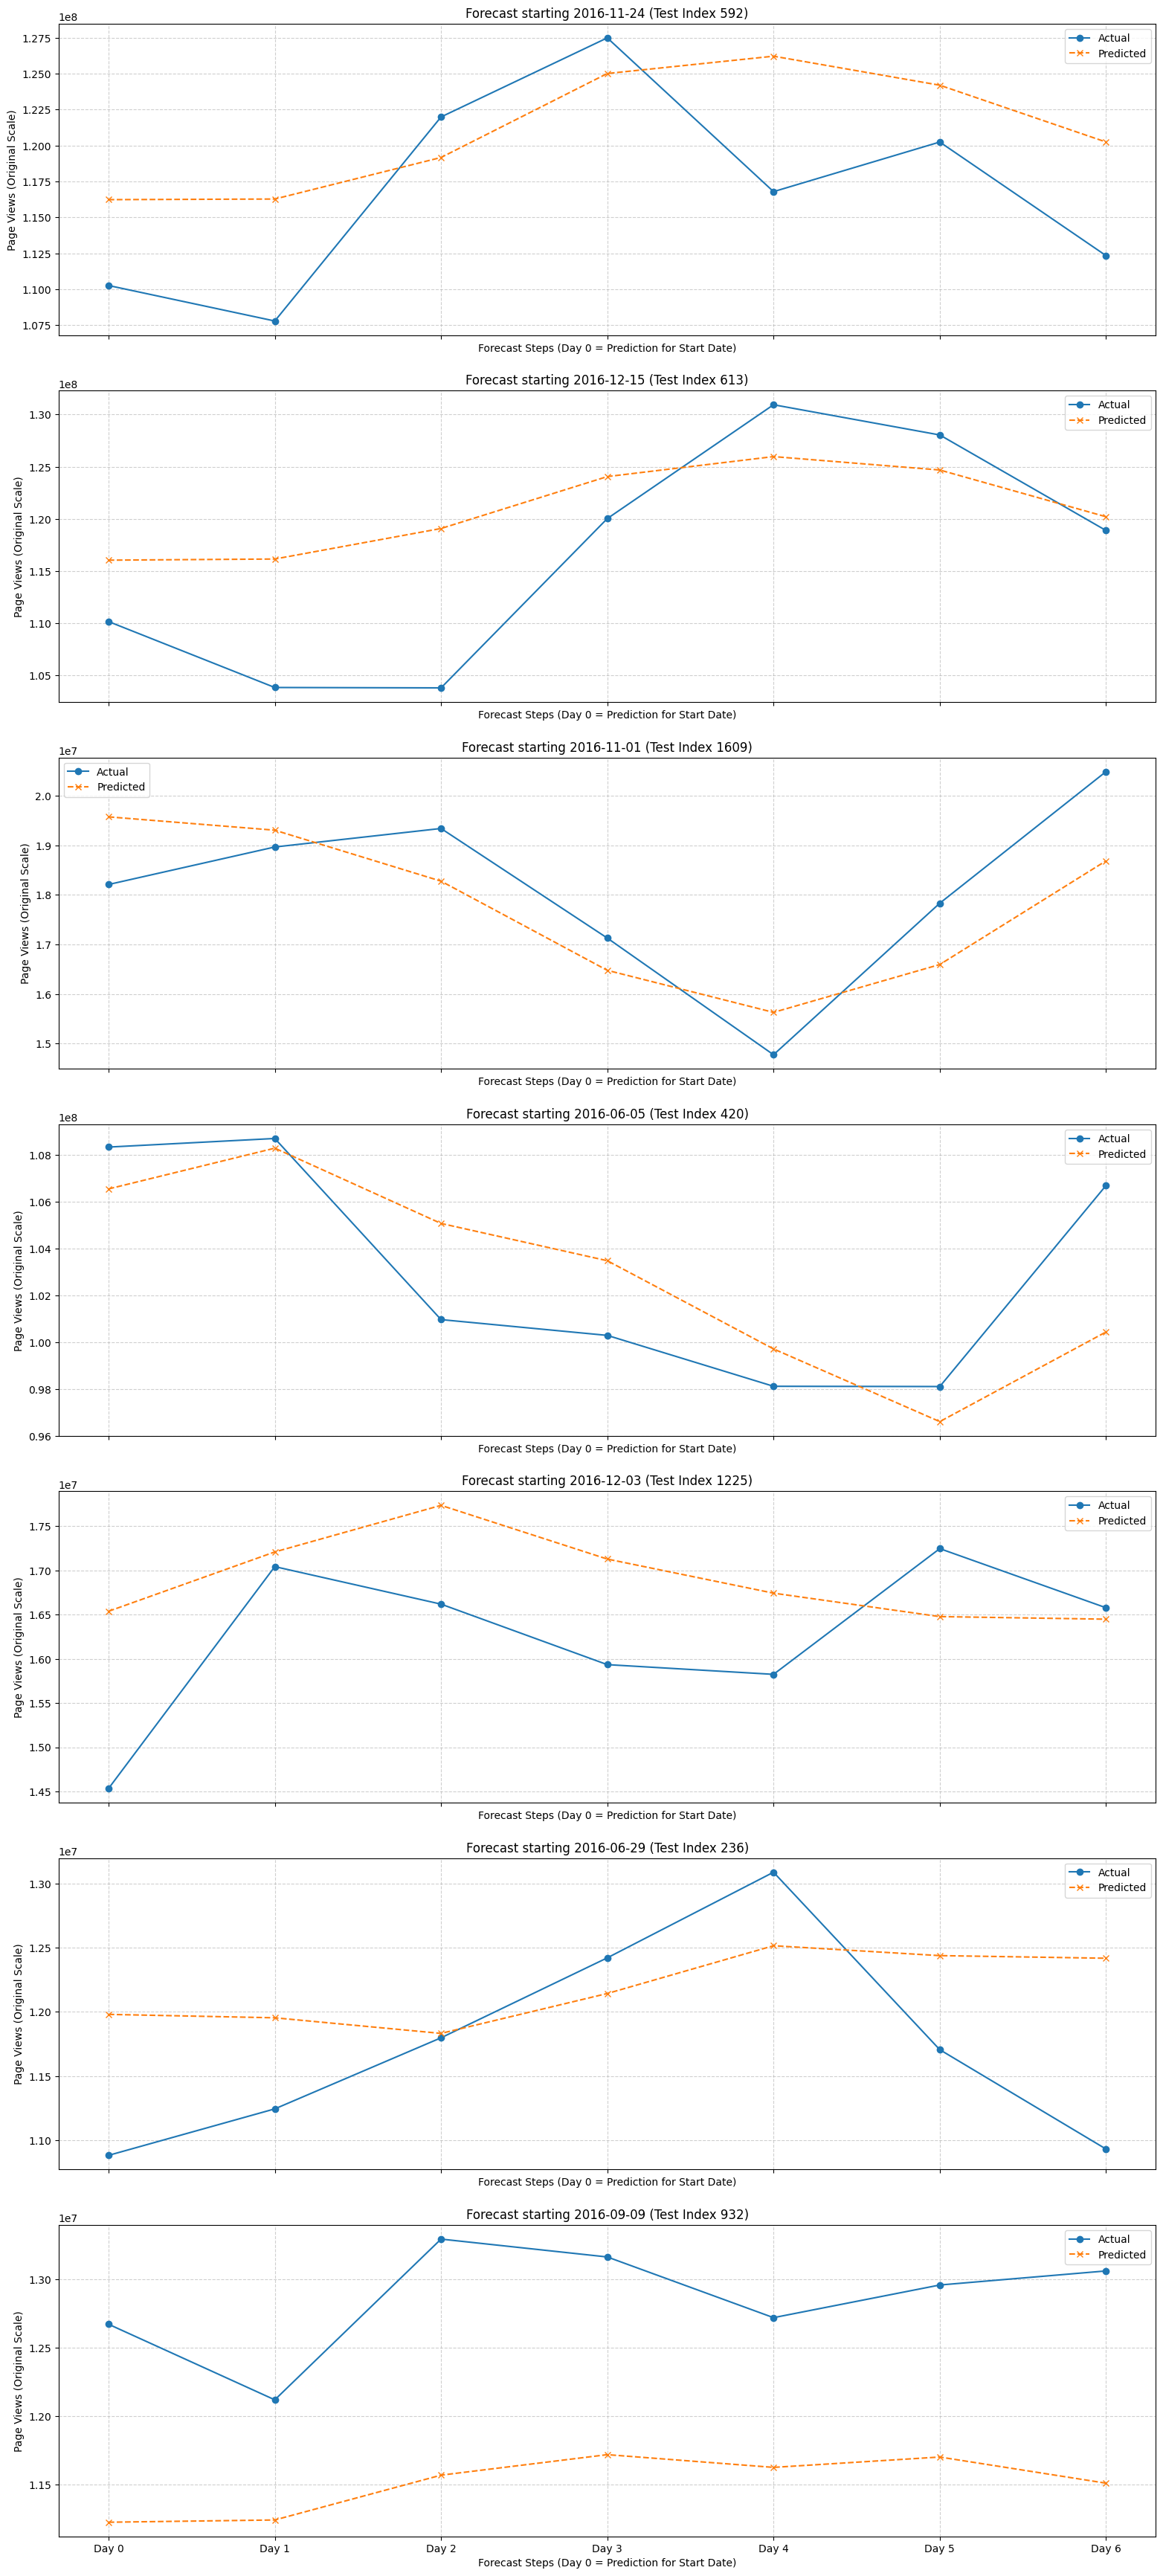

In [15]:
# %%
# --- Prediction and Visualization (Using the BEST Tuned Model) ---
# IMPORTANT: Run this cell AFTER you have retrained the model
# using the best hyperparameters found by Ray Tune.

import matplotlib.pyplot as plt
import random
import torch
import numpy as np
import gc

print("--- Preparing for Visualization ---")

# --- Check for Essential Variables ---
essential_vars_viz = ['test_dataset', 'test_dates_list', 'model', 'device',
                      'TARGETS_SCALED', 'DO_LOG_TRANSFORM', 'y_test'] # Added y_test for target count
if TARGETS_SCALED: essential_vars_viz.append('scaler_target')
# Note: scaler_context is not strictly needed for plotting unless you want to visualize context features

vars_exist = True
for var_name in essential_vars_viz:
    if var_name not in locals():
        print(f"ERROR: Essential variable '{var_name}' is not defined for visualization.")
        print("Please ensure Cells 1, 2, 3, and the FINAL training cell (using best params) were run.")
        vars_exist = False

if vars_exist:
    print(f"Using model: {type(model)}") # Confirm model object exists
    print(f"Test dataset size: {len(test_dataset)}")
    print(f"Test dates list size: {len(test_dates_list)}")
    if len(test_dataset) != len(test_dates_list):
         print("Warning: Length mismatch between test_dataset and test_dates_list!")

    # --- Define Plotting Parameters ---
    try:
        num_targets = y_test.shape[1] # Get from y_test tensor shape
        target_labels = [f'Day {i}' for i in range(num_targets)]
        forecast_horizon = list(range(num_targets))
        print(f"Plotting {num_targets} target days.")
    except Exception as e:
        print(f"Warning: Could not determine num_targets from y_test ({e}). Assuming 7.")
        num_targets = 7
        target_labels = [f'Day {i}' for i in range(num_targets)]
        forecast_horizon = list(range(num_targets))

    # --- Plotting Setup ---
    num_samples_to_plot = 7 # Number of random examples
    if len(test_dataset) == 0:
        print("Test dataset is empty. Cannot generate plots.")
        num_samples_to_plot = 0
    elif len(test_dataset) < num_samples_to_plot:
        print(f"Warning: Requested {num_samples_to_plot} plots, but test dataset only has {len(test_dataset)} samples.")
        num_samples_to_plot = len(test_dataset)

    if num_samples_to_plot > 0 :
        random_indices = random.sample(range(len(test_dataset)), num_samples_to_plot)
        n_plots = len(random_indices)
        ncols = 1
        nrows = n_plots

        fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 5), sharex=True, squeeze=False) # Slightly larger plots
        axes = axes.flatten()

        # Ensure model is in evaluation mode (important after training)
        model.eval()
        print(f"\nGenerating {num_samples_to_plot} sample prediction plots...")
        with torch.no_grad(): # Disable gradient calculations for inference
            plot_counter = 0
            for i, idx in enumerate(random_indices):
                print(f"  Processing plot for test index {idx}...")
                try:
                    # --- Get data from dataset ---
                    # Dataset yields (sequence, context, target)
                    sample_seq, sample_context, sample_actual_scaled = test_dataset[idx]

                    # Get the corresponding date
                    sample_date = test_dates_list[idx]

                    # --- Prepare data for model ---
                    # Add batch dimension [1, ...] and move to device
                    sample_seq_batch = sample_seq.unsqueeze(0).to(device)
                    sample_context_batch = sample_context.unsqueeze(0).to(device)

                    # --- Get prediction ---
                    # Model takes seq and context
                    predicted_scaled = model(sample_seq_batch, sample_context_batch).squeeze(0).cpu().numpy()

                    # --- Inverse Transform ---
                    actual_series_scaled = sample_actual_scaled.numpy() # Get numpy array for actual scaled values

                    plot_ylabel = "Value" # Default y-axis label

                    if TARGETS_SCALED:
                        # Reshape for scaler (expects 2D array: [samples, features])
                        predicted_series_inv = scaler_target.inverse_transform(predicted_scaled.reshape(1, -1))[0]
                        actual_series_inv = scaler_target.inverse_transform(actual_series_scaled.reshape(1, -1))[0]
                        plot_ylabel = "Page Views (Original Scale)"
                         # Reverse log transform if applied
                        if DO_LOG_TRANSFORM:
                             predicted_series_final = np.expm1(predicted_series_inv)
                             actual_series_final = np.expm1(actual_series_inv)
                             # print(f"  Index {idx}: Applied expm1.")
                        else:
                             predicted_series_final = predicted_series_inv
                             actual_series_final = actual_series_inv
                    else: # Targets were not scaled
                        predicted_series_final = predicted_scaled
                        actual_series_final = actual_series_scaled # Already in original (or log) scale
                        plot_ylabel = "Page Views (Not Scaled)"
                        # Reverse log transform if it was applied
                        if DO_LOG_TRANSFORM:
                             predicted_series_final = np.expm1(predicted_series_final)
                             actual_series_final = np.expm1(actual_series_final)
                             plot_ylabel = "Page Views (Original Scale - from Log)"
                             # print(f"  Index {idx}: Applied expm1.")


                    # --- Plotting ---
                    ax = axes[plot_counter]
                    ax.plot(forecast_horizon, actual_series_final, marker='o', linestyle='-', linewidth=1.5, label='Actual')
                    ax.plot(forecast_horizon, predicted_series_final, marker='x', linestyle='--', linewidth=1.5, label='Predicted')

                    # Format title/labels
                    try: title_date = sample_date.strftime('%Y-%m-%d')
                    except: title_date = str(sample_date) # Fallback
                    ax.set_title(f"Forecast starting {title_date} (Test Index {idx})", fontsize=12)
                    ax.set_xlabel(f"Forecast Steps ({target_labels[0]} = Prediction for Start Date)")
                    ax.set_ylabel(plot_ylabel)
                    ax.legend()
                    ax.grid(True, linestyle='--', alpha=0.6)
                    ax.set_xticks(forecast_horizon)
                    ax.set_xticklabels(target_labels)
                    # Optional: Add text annotation for RMSE/MAE for this specific forecast
                    # error = np.sqrt(np.mean((predicted_series_final - actual_series_final)**2))
                    # ax.text(0.05, 0.9, f'RMSE: {error:.2f}', transform=ax.transAxes, verticalalignment='top')


                    plot_counter += 1

                except Exception as e:
                    print(f"  ERROR processing plot for index {idx}: {e}")
                    # Optionally print traceback for debugging
                    # import traceback
                    # traceback.print_exc()
                    # Ensure the specific subplot for the error is left blank or marked
                    if plot_counter < len(axes):
                         axes[plot_counter].set_title(f"Error plotting index {idx}")
                         axes[plot_counter].text(0.5, 0.5, 'Error during plot generation', horizontalalignment='center', verticalalignment='center')


        # Clean up unused subplots
        for j in range(plot_counter, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout(pad=2.0) # Add padding
        plt.show()
        gc.collect() # Clean up plot memory

else:
    print("\nCannot generate plots because essential variables are missing.")

In [12]:
# config = 
# {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0027085717992968443, 'dropout_prob': 0.11949688027179968, 'weight_decay': 2.2003081064519322e-07, 'batch_size': 128}
config = {
    'hidden_size': 128,
    'num_layers': 2,
    'lr': 0.0027085717992968443,
    'dropout_prob': 0.11949688027179968,
    'weight_decay': 2.2003081064519322e-07,
    'batch_size': 128
}

# Load the best model
model = LSTMForecastModel(
    sequence_input_size=SEQUENCE_INPUT_SIZE,
    context_input_size=CONTEXT_INPUT_SIZE,
    hidden_size=config["hidden_size"],
    num_layers=config["num_layers"],
    output_size=OUTPUT_SIZE,
    dropout_prob=config["dropout_prob"]
).to(device)

best_model_path = 'final_best_lstm_model.pth'  # Path to the saved best model
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set the model to evaluation mode
print(f"Best model loaded from {best_model_path}.")

# score model with l1, l2, and r2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


l1_losses = []
l2_losses = []
r2_losses = []
with torch.no_grad():
    for seq_data, context_data, targets in test_loader:
        seq_data = seq_data.to(device)
        context_data = context_data.to(device)
        targets = targets.to(device)

        outputs = model(seq_data, context_data)


        # Convert tensors to numpy arrays
        outputs_np = outputs.cpu().numpy()
        targets_np = targets.cpu().numpy()
        if TARGETS_SCALED:
            # Inverse transform if targets were scaled
            outputs_np = scaler_target.inverse_transform(outputs_np)
            targets_np = scaler_target.inverse_transform(targets_np)
        if DO_LOG_TRANSFORM:
            # Reverse log transform if applied
            outputs_np = np.expm1(outputs_np)
            targets_np = np.expm1(targets_np)

        # Calculate L1, L2, and R2 losses
        l1_loss = mean_absolute_error(targets_np, outputs_np)
        l2_loss = mean_squared_error(targets_np, outputs_np)
        r2_loss = r2_score(targets_np, outputs_np)

        l1_losses.append(l1_loss)
        l2_losses.append(l2_loss)
        r2_losses.append(r2_loss)
# Calculate average losses
avg_l1_loss = np.mean(l1_losses)
avg_l2_loss = np.mean(l2_losses)
avg_r2_loss = np.mean(r2_losses)
print(f"Average L1 Loss: {avg_l1_loss:.6f}")
print(f"Average L2 Loss: {avg_l2_loss:.6f}")
print(f"Average R2 Loss: {avg_r2_loss:.6f}")

Best model loaded from final_best_lstm_model.pth.
Average L1 Loss: 2874111.230769
Average L2 Loss: 81994261918011.078125
Average R2 Loss: 0.409039
